In [1]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModel
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, metrics, regularizers
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import sys

/home/yu/kaggle-tweet-sentiment/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-02 12:20:12.749565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738516812.761070  162194 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738516812.764498  162194 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 12:20:12.776531: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performan

In [2]:
train = pd.read_csv("data/train.csv").dropna()
train, test = train_test_split(train, test_size=0.15)
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 23358 entries, 24777 to 13779
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         23358 non-null  object
 1   text           23358 non-null  object
 2   selected_text  23358 non-null  object
 3   sentiment      23358 non-null  object
dtypes: object(4)
memory usage: 912.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 4122 entries, 12352 to 22757
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         4122 non-null   object
 1   text           4122 non-null   object
 2   selected_text  4122 non-null   object
 3   sentiment      4122 non-null   object
dtypes: object(4)
memory usage: 161.0+ KB
None


In [3]:
max_text_len = 128
inference_batch_size = 1000

def tokenize(texts, padding=True):
    padding = "max_length" if padding else "longest"
    return tokenizer(texts, padding=padding, max_length=max_text_len, return_tensors="tf")

def detokenize(ids, skip_special=True):
    return tokenizer.batch_decode(ids, skip_special_tokens=skip_special)

# https://stackoverflow.com/a/7100681
def rolling_window(a, size):
    shape = a.shape[:-1] + (a.shape[-1] - size + 1, size)
    strides = a.strides + (a. strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def find_span(texts, spans, word_boundary=False):
    texts = np.array(texts)
    spans = np.array(spans)[:, 1:]
    sizes = spans.argmin(axis=1) - 1
    span_ranges = np.zeros((texts.shape[0], 2))
    for i, text in enumerate(texts):
        skips = 0
        window_size = sizes[i]
        if word_boundary:
            allowed = set(texts[i])
            if spans[i, 0] not in allowed and window_size > 1:
                skips = 1
            if spans[i, -1] not in allowed and window_size - skips > 1:
                window_size -= 1
        matched_window = rolling_window(texts[i], window_size - skips) == spans[i][skips:window_size]
        window_from = matched_window.all(axis=1).argmax()
        span_ranges[i, 0] = window_from
        span_ranges[i, 1] = window_from + window_size - 1
    return span_ranges

def eprint(*args, **kwargs):
    print(*args, **kwargs, file=sys.stderr)

def print_mem_info():
    info = tf.config.experimental.get_memory_info("/gpu:0")
    eprint(f"GPU memory usage {(info["current"] / info["peak"]):.2f}.")

def context_embeddings(texts, sentiments, selected_texts=None):
    text_tokens = tokenize(texts)
    text_embeddings = encoder(**text_tokens).last_hidden_state
    sentiment_tokens = tokenize(sentiments)
    sentiment_embeddings = encoder(**sentiment_tokens).last_hidden_state[:, 1:2, :]  # only need embedding for one word
    embeddings = tf.concat((text_embeddings, sentiment_embeddings), 1)
    if selected_texts is None:
        return embeddings
    else:
        selected_tokens = tokenize(selected_texts)
        targets = find_span(text_tokens["input_ids"], selected_tokens["input_ids"], word_boundary=True)
        return embeddings, targets

def dataset_generator(texts, sentiments, selected_texts=None):
    def gen():
        total = len(texts)
        yielded = 0
        while yielded < total:
            batch_i = yielded % inference_batch_size
            # batch inferencing
            if batch_i == 0:
                end = min(total, yielded + inference_batch_size)
                if selected_texts is None:
                    embeddings = context_embeddings(texts[yielded:end], sentiments[yielded:end])
                else:
                    embeddings, targets = context_embeddings(texts[yielded:end], sentiments[yielded:end], selected_texts[yielded:end])
            # feed the generator
            if selected_texts is None:
                yield embeddings[batch_i]
            else:
                yield embeddings[batch_i], (targets[batch_i, 0], targets[batch_i, 1])
            yielded += 1
    return gen

Naive implementation, flattened embeddings into FFN with one hidden layer.

In [4]:
inputs = keras.Input(shape=(1 + max_text_len, 768))
flat = layers.Flatten()(inputs)
hidden = layers.Dense(8192, activation="relu", kernel_regularizer="l1l2", bias_regularizer="l2")(flat)
softmax_start = layers.Dense(max_text_len, activation="softmax", name="start", kernel_regularizer="l1l2", bias_regularizer="l2")(hidden)
softmax_end = layers.Dense(max_text_len, activation="softmax", name="end", kernel_regularizer="l1l2", bias_regularizer="l2")(hidden)
ffn = keras.Model(inputs=inputs, outputs=(softmax_start, softmax_end))
ffn.compile(
    optimizer=optimizers.Adam(),
    loss={"start": losses.SparseCategoricalCrossentropy(), "end": losses.SparseCategoricalCrossentropy()},
    metrics={"start": metrics.SparseCategoricalAccuracy(), "end": metrics.SparseCategoricalAccuracy()}
)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
encoder = TFAutoModel.from_pretrained("distilbert-base-uncased")
dataset_train = tf.data.Dataset.from_generator(
    dataset_generator(train.text.to_list(), train.sentiment.to_list(), train.selected_text.to_list()),
    output_signature=(tf.TensorSpec(shape=(1 + max_text_len, 768)), (tf.TensorSpec(shape=()), tf.TensorSpec(shape=())))
).shuffle(inference_batch_size)
dataset_test = tf.data.Dataset.from_generator(
    dataset_generator(test.text.to_list(), test.sentiment.to_list(), test.selected_text.to_list()),
    output_signature=(tf.TensorSpec(shape=(1 + max_text_len, 768)), (tf.TensorSpec(shape=()), tf.TensorSpec(shape=())))
)
history = ffn.fit(dataset_train.batch(64), epochs=10, validation_data=dataset_test.batch(64))

I0000 00:00:1738516815.007711  162194 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21783 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.

Epoch 1/10


I0000 00:00:1738516822.645235  162373 service.cc:148] XLA service 0x7f720c0052f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738516822.645256  162373 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-02 12:20:22.670607: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738516822.757277  162373 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-02 12:20:23.504408: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 192 bytes spill stores, 192 bytes spill loads

2025-02-02 12:20:23.578193: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 124 bytes spil

      3/Unknown 8s 66ms/step - end_loss: 23.3097 - end_sparse_categorical_accuracy: 0.0165 - loss: 94.3893 - start_loss: 71.0795 - start_sparse_categorical_accuracy: 0.2431

I0000 00:00:1738516824.369948  162373 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    364/Unknown 68s 165ms/step - end_loss: 16.1736 - end_sparse_categorical_accuracy: 0.3445 - loss: 32.3781 - start_loss: 16.2040 - start_sparse_categorical_accuracy: 0.5003 

2025-02-02 12:21:24.994161: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 8 bytes spill stores, 8 bytes spill loads

2025-02-02 12:21:25.066724: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads

2025-02-02 12:21:25.301943: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 240 bytes spill stores, 240 bytes spill loads

2025-02-02 12:21:25.516790: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 20 bytes spill stores, 20 bytes spill loads

2025-02-02 12:21:25.534776: I external/local_xla/xla/stream_executor/cuda/cuda_a

    365/Unknown 70s 170ms/step - end_loss: 16.1450 - end_sparse_categorical_accuracy: 0.3448 - loss: 32.3194 - start_loss: 16.1739 - start_sparse_categorical_accuracy: 0.5005

2025-02-02 12:21:26.217459: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-02-02 12:21:26.217483: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2025-02-02 12:21:26.217492: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:21:26.217496: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:21:26.217505: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945
/home/yu/kaggle-tweet-sentiment/.venv/lib64/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interr

365/365 ━━━━━━━━━━━━━━━━━━━━ 80s 198ms/step - end_loss: 16.1165 - end_sparse_categorical_accuracy: 0.3452 - loss: 32.2611 - start_loss: 16.1440 - start_sparse_categorical_accuracy: 0.5006 - val_end_loss: 1.7151 - val_end_sparse_categorical_accuracy: 0.5580 - val_loss: 3.2719 - val_start_loss: 1.5515 - val_start_sparse_categorical_accuracy: 0.5704
Epoch 2/10


2025-02-02 12:21:36.609609: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2025-02-02 12:21:36.609633: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:21:36.609639: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:21:36.609646: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945


364/365 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - end_loss: 1.4779 - end_sparse_categorical_accuracy: 0.5969 - loss: 2.8710 - start_loss: 1.3930 - start_sparse_categorical_accuracy: 0.6017 

2025-02-02 12:22:41.077956: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:22:41.078017: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:22:41.078027: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945


365/365 ━━━━━━━━━━━━━━━━━━━━ 74s 192ms/step - end_loss: 1.4775 - end_sparse_categorical_accuracy: 0.5970 - loss: 2.8704 - start_loss: 1.3928 - start_sparse_categorical_accuracy: 0.6017 - val_end_loss: 1.6837 - val_end_sparse_categorical_accuracy: 0.5541 - val_loss: 3.2215 - val_start_loss: 1.5310 - val_start_sparse_categorical_accuracy: 0.5762
Epoch 3/10


2025-02-02 12:22:50.331400: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2025-02-02 12:22:50.331428: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:22:50.331434: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:22:50.331442: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945


365/365 ━━━━━━━━━━━━━━━━━━━━ 75s 195ms/step - end_loss: 1.1171 - end_sparse_categorical_accuracy: 0.6676 - loss: 2.2231 - start_loss: 1.1060 - start_sparse_categorical_accuracy: 0.6655 - val_end_loss: 1.8127 - val_end_sparse_categorical_accuracy: 0.5444 - val_loss: 3.4101 - val_start_loss: 1.5895 - val_start_sparse_categorical_accuracy: 0.5687
Epoch 4/10


2025-02-02 12:24:04.903828: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:24:04.903855: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:24:04.903864: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945


364/365 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - end_loss: 0.7840 - end_sparse_categorical_accuracy: 0.7582 - loss: 1.6193 - start_loss: 0.8353 - start_sparse_categorical_accuracy: 0.7337 

2025-02-02 12:25:09.319929: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:25:09.319951: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:25:09.319961: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945


365/365 ━━━━━━━━━━━━━━━━━━━━ 73s 191ms/step - end_loss: 0.7838 - end_sparse_categorical_accuracy: 0.7583 - loss: 1.6189 - start_loss: 0.8351 - start_sparse_categorical_accuracy: 0.7338 - val_end_loss: 2.0545 - val_end_sparse_categorical_accuracy: 0.5340 - val_loss: 3.8263 - val_start_loss: 1.7692 - val_start_sparse_categorical_accuracy: 0.5502
Epoch 5/10


2025-02-02 12:25:18.356483: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2025-02-02 12:25:18.356512: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:25:18.356518: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:25:18.356527: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945


364/365 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - end_loss: 0.5540 - end_sparse_categorical_accuracy: 0.8218 - loss: 1.1428 - start_loss: 0.5888 - start_sparse_categorical_accuracy: 0.8125 

2025-02-02 12:26:23.192376: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:26:23.192399: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:26:23.192408: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945


365/365 ━━━━━━━━━━━━━━━━━━━━ 74s 193ms/step - end_loss: 0.5538 - end_sparse_categorical_accuracy: 0.8219 - loss: 1.1424 - start_loss: 0.5886 - start_sparse_categorical_accuracy: 0.8126 - val_end_loss: 2.1372 - val_end_sparse_categorical_accuracy: 0.5332 - val_loss: 4.1399 - val_start_loss: 1.9941 - val_start_sparse_categorical_accuracy: 0.5607
Epoch 6/10


2025-02-02 12:26:32.361822: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:26:32.361848: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:26:32.361857: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945


365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - end_loss: 0.3937 - end_sparse_categorical_accuracy: 0.8719 - loss: 0.8004 - start_loss: 0.4067 - start_sparse_categorical_accuracy: 0.8661  

2025-02-02 12:27:38.050026: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:27:38.050065: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:27:38.050075: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945


365/365 ━━━━━━━━━━━━━━━━━━━━ 75s 196ms/step - end_loss: 0.3936 - end_sparse_categorical_accuracy: 0.8719 - loss: 0.8003 - start_loss: 0.4067 - start_sparse_categorical_accuracy: 0.8661 - val_end_loss: 2.4839 - val_end_sparse_categorical_accuracy: 0.5269 - val_loss: 4.7173 - val_start_loss: 2.2210 - val_start_sparse_categorical_accuracy: 0.5854
Epoch 7/10


2025-02-02 12:27:47.275721: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:27:47.275747: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:27:47.275756: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945


364/365 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - end_loss: 0.2874 - end_sparse_categorical_accuracy: 0.9045 - loss: 0.5777 - start_loss: 0.2903 - start_sparse_categorical_accuracy: 0.9038  

2025-02-02 12:28:52.390574: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:28:52.390596: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:28:52.390605: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945


365/365 ━━━━━━━━━━━━━━━━━━━━ 75s 194ms/step - end_loss: 0.2873 - end_sparse_categorical_accuracy: 0.9046 - loss: 0.5775 - start_loss: 0.2902 - start_sparse_categorical_accuracy: 0.9039 - val_end_loss: 2.6301 - val_end_sparse_categorical_accuracy: 0.5391 - val_loss: 5.0700 - val_start_loss: 2.4309 - val_start_sparse_categorical_accuracy: 0.5832
Epoch 8/10


2025-02-02 12:29:01.844165: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:29:01.844202: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:29:01.844212: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945


364/365 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - end_loss: 0.2176 - end_sparse_categorical_accuracy: 0.9281 - loss: 0.4285 - start_loss: 0.2108 - start_sparse_categorical_accuracy: 0.9309 

2025-02-02 12:30:06.269178: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:30:06.269226: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:30:06.269235: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945


365/365 ━━━━━━━━━━━━━━━━━━━━ 73s 191ms/step - end_loss: 0.2176 - end_sparse_categorical_accuracy: 0.9282 - loss: 0.4284 - start_loss: 0.2108 - start_sparse_categorical_accuracy: 0.9309 - val_end_loss: 2.8588 - val_end_sparse_categorical_accuracy: 0.5291 - val_loss: 5.4450 - val_start_loss: 2.5621 - val_start_sparse_categorical_accuracy: 0.5582
Epoch 9/10


2025-02-02 12:30:15.318018: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2025-02-02 12:30:15.318046: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:30:15.318052: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:30:15.318060: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945


365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - end_loss: 0.2142 - end_sparse_categorical_accuracy: 0.9281 - loss: 0.4065 - start_loss: 0.1923 - start_sparse_categorical_accuracy: 0.9345 

2025-02-02 12:31:20.470012: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:31:20.470093: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:31:20.470104: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945


365/365 ━━━━━━━━━━━━━━━━━━━━ 74s 194ms/step - end_loss: 0.2142 - end_sparse_categorical_accuracy: 0.9281 - loss: 0.4064 - start_loss: 0.1922 - start_sparse_categorical_accuracy: 0.9345 - val_end_loss: 3.1292 - val_end_sparse_categorical_accuracy: 0.5403 - val_loss: 6.0057 - val_start_loss: 2.8621 - val_start_sparse_categorical_accuracy: 0.5643
Epoch 10/10


2025-02-02 12:31:29.734489: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:31:29.734514: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:31:29.734523: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945


365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - end_loss: 0.2069 - end_sparse_categorical_accuracy: 0.9292 - loss: 0.3898 - start_loss: 0.1829 - start_sparse_categorical_accuracy: 0.9386  

2025-02-02 12:32:34.589595: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:32:34.589620: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:32:34.589629: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945


365/365 ━━━━━━━━━━━━━━━━━━━━ 74s 192ms/step - end_loss: 0.2069 - end_sparse_categorical_accuracy: 0.9292 - loss: 0.3898 - start_loss: 0.1829 - start_sparse_categorical_accuracy: 0.9386 - val_end_loss: 3.5610 - val_end_sparse_categorical_accuracy: 0.5412 - val_loss: 6.7605 - val_start_loss: 3.1759 - val_start_sparse_categorical_accuracy: 0.5631


2025-02-02 12:32:43.541545: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16398267048219877601
2025-02-02 12:32:43.541572: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3308989629776575609
2025-02-02 12:32:43.541580: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14814014650914217945


In [5]:
# https://www.kaggle.com/competitions/tweet-sentiment-extraction
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

score = 0
total = test.shape[0]
(y_start, y_end) = ffn.predict(dataset_test.batch(64))
y_start = tf.math.argmax(y_start, axis=1)
y_end = tf.math.argmax(y_end, axis=1) + 1
spans_pred = []
for i in range(total):
    span_start = y_start[i]
    span_end = y_end[i]
    y_str = test.text.iloc[i][span_start:span_end]
    spans_pred.append((test.text.iloc[i], y_str))
    t_str = test.selected_text.iloc[i]
    score += 1 / total * jaccard(y_str, t_str)
score

65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step


0.11111242392803983

Text(0.5, 0, 'Epoch')

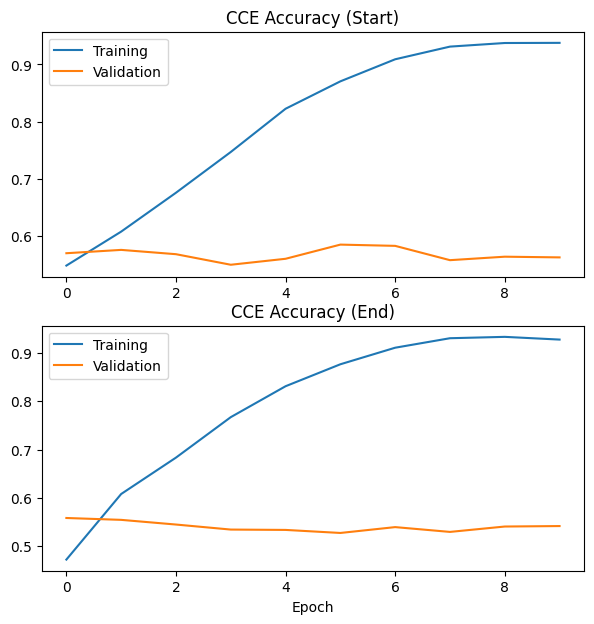

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))

ax1.plot(history.history["start_sparse_categorical_accuracy"])
ax1.plot(history.history["val_start_sparse_categorical_accuracy"])
ax1.legend(["Training", "Validation"])
ax1.title.set_text("CCE Accuracy (Start)")

ax2.plot(history.history["end_sparse_categorical_accuracy"])
ax2.plot(history.history["val_end_sparse_categorical_accuracy"])
ax2.legend(["Training", "Validation"])
ax2.title.set_text("CCE Accuracy (End)")

plt.xlabel("Epoch")